In [1]:
# Install Qiskit with Aqua
!pip install qiskit qiskit-aer sympy --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.5 MB/s eta 0:00:00


In [10]:
!pip install pylatexenc --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [6]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from math import gcd
from sympy import Rational
import matplotlib.pyplot as plt
import numpy as np

In [14]:
# Block 3 – Define Parameters
# Number to factor
N = 15
# Random base coprime to N
a = 7

# Counting qubits (for phase estimation) + register qubits (for modular exponentiation)
n_count = 3   # counting qubits
n_register = 3  # register qubits

In [15]:
# Block 4 – Define Quantum Circuit
qc = QuantumCircuit(n_count + n_register, n_count)

# Step 1: Apply Hadamards to counting qubits
qc.h(range(n_count))

# Step 2: Initialize register to |1>
qc.x(n_count)

# --- Placeholder for modular exponentiation ---
qc.cx(0, n_count)      # control from counting qubit 0
qc.cx(1, n_count+1)    # control from counting qubit 1
qc.cx(2, n_count+2)    # control from counting qubit 2

# Step 3: Apply inverse QFT to counting qubits
def qft_dagger(circ, n):
    """Inverse Quantum Fourier Transform on first n qubits."""
    for qubit in range(n//2):
        circ.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            circ.cp(-np.pi/float(2**(j-m)), m, j)
        circ.h(j)

qft_dagger(qc, n_count)

# Step 4: Measurement
qc.measure(range(n_count), range(n_count))

In [16]:
# Block 5 – Draw the Circuit (safe fallback if pylatexenc missing)
try:
    qc.draw("mpl")
except Exception:
    print("⚠️ Falling back to text circuit representation.")
    print(qc.draw("text"))


⚠️ Falling back to text circuit representation.
     ┌───┐                  ┌───┐                                   ┌─┐        »
q_0: ┤ H ├──■─────────────X─┤ H ├─■──────────────■──────────────────┤M├────────»
     ├───┤  │             │ └───┘ │P(-π/2) ┌───┐ │                  └╥┘     ┌─┐»
q_1: ┤ H ├──┼────■────────┼───────■────────┤ H ├─┼─────────■─────────╫──────┤M├»
     ├───┤  │    │        │                └───┘ │P(-π/4)  │P(-π/2)  ║ ┌───┐└╥┘»
q_2: ┤ H ├──┼────┼────■───X──────────────────────■─────────■─────────╫─┤ H ├─╫─»
     ├───┤┌─┴─┐  │    │                                              ║ └───┘ ║ »
q_3: ┤ X ├┤ X ├──┼────┼──────────────────────────────────────────────╫───────╫─»
     └───┘└───┘┌─┴─┐  │                                              ║       ║ »
q_4: ──────────┤ X ├──┼──────────────────────────────────────────────╫───────╫─»
               └───┘┌─┴─┐                                            ║       ║ »
q_5: ───────────────┤ X ├────────────────────────────────────

In [18]:
# Block 6 – Run the Simulation and Plot Histogram
from qiskit.visualization import plot_histogram

backend = Aer.get_backend("aer_simulator")
tqc = transpile(qc, backend)
result = backend.run(tqc, shots=2048).result()

counts = result.get_counts()
print("Measurement counts:", counts)

# Plot histogram
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plot_histogram(counts)
plt.show()


Measurement counts: {'001': 258, '000': 255, '010': 261, '101': 252, '100': 256, '011': 267, '111': 257, '110': 242}


<Figure size 800x500 with 0 Axes>

Measurement counts: {'100': 266, '010': 255, '000': 278, '001': 233, '101': 251, '110': 222, '011': 272, '111': 271}


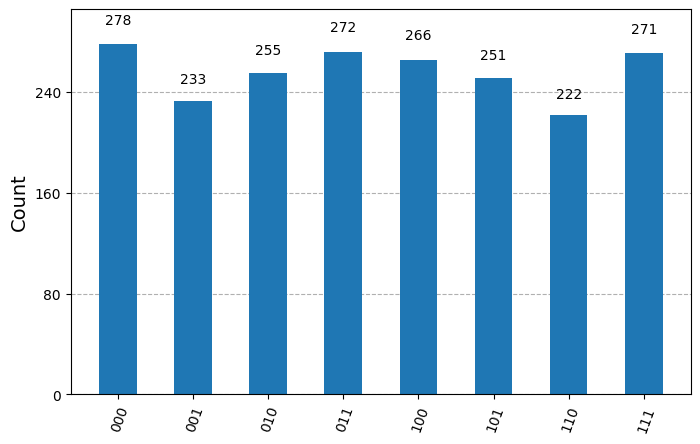

In [19]:
# Block 6 – Run the Simulation and Plot Histogram (Fixed)
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

backend = Aer.get_backend("aer_simulator")
tqc = transpile(qc, backend)
result = backend.run(tqc, shots=2048).result()

counts = result.get_counts()
print("Measurement counts:", counts)

# Correct plotting
fig, ax = plt.subplots(figsize=(8, 5))
plot_histogram(counts, ax=ax)
plt.show()

In [21]:
# Block 7 – Visualize Single-Qubit States (Partial Trace + Bloch Sphere)
from qiskit.quantum_info import Statevector, partial_trace
from qiskit.visualization import plot_bloch_multivector

# Make a copy of the circuit without measurements
qc_nom = qc.remove_final_measurements(inplace=False)

# Get the final statevector after the circuit (no measurement)
state = Statevector.from_instruction(qc_nom)

# Partial trace: look at reduced states of each qubit
for qubit in range(n_count):
    reduced = partial_trace(state, [i for i in range(qc.num_qubits) if i != qubit])
    print(f"\nReduced density matrix for qubit {qubit}:")
    print(reduced)

# Plot Bloch vectors for all qubits
plot_bloch_multivector(state)
plt.show()


Reduced density matrix for qubit 0:
DensityMatrix([[5.00000000e-01+0.00000000e+00j,
                2.97631495e-19-2.97631495e-19j],
               [2.97631495e-19+2.97631495e-19j,
                5.00000000e-01+0.00000000e+00j]],
              dims=(2,))

Reduced density matrix for qubit 1:
DensityMatrix([[0.5+0.00000000e+00j, 0. +1.15890825e-18j],
               [0. -1.15890825e-18j, 0.5+0.00000000e+00j]],
              dims=(2,))

Reduced density matrix for qubit 2:
DensityMatrix([[5.00000000e-01+0.j, 2.08166817e-17+0.j],
               [2.08166817e-17+0.j, 5.00000000e-01+0.j]],
              dims=(2,))


Qubit 0 Bloch vector: X=0.000, Y=0.000, Z=0.000
Qubit 1 Bloch vector: X=0.000, Y=-0.000, Z=0.000
Qubit 2 Bloch vector: X=0.000, Y=0.000, Z=0.000


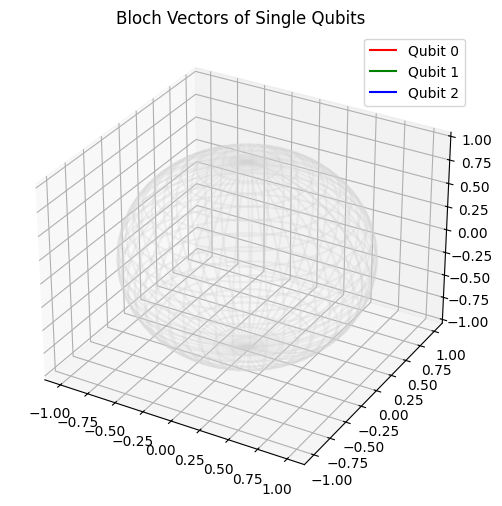

In [24]:
from qiskit.quantum_info import Statevector, partial_trace, Operator
import numpy as np
import matplotlib.pyplot as plt

# Remove measurements and get the statevector
qc_nom = qc.remove_final_measurements(inplace=False)
state = Statevector.from_instruction(qc_nom)

# Pauli matrices
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])

bloch_vectors = []

for qubit in range(n_count):
    reduced = partial_trace(state, [i for i in range(qc.num_qubits) if i != qubit])
    rho = reduced.data  # density matrix as np.array

    # Expectation values
    bx = np.real(np.trace(rho @ X))
    by = np.real(np.trace(rho @ Y))
    bz = np.real(np.trace(rho @ Z))

    bloch_vectors.append([bx, by, bz])
    print(f"Qubit {qubit} Bloch vector: X={bx:.3f}, Y={by:.3f}, Z={bz:.3f}")

# Plot manually
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

# Draw sphere
u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:25j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)
ax.plot_wireframe(x, y, z, color="lightgray", alpha=0.3)

# Plot each qubit’s Bloch vector
colors = ['r','g','b']
for i, vec in enumerate(bloch_vectors):
    ax.quiver(0,0,0, vec[0], vec[1], vec[2], color=colors[i], label=f"Qubit {i}")

ax.set_title("Bloch Vectors of Single Qubits")
ax.legend()
plt.show()

In [27]:
# Block 8 – Visualize Full Quantum State Evolution as a GIF (Fixed Again)
from qiskit.quantum_info import Statevector
import imageio
import matplotlib.pyplot as plt
import io

frames = []

# Copy circuit without measurements (so we can evolve smoothly)
qc_nom = qc.remove_final_measurements(inplace=False)

# Initial state
state = Statevector.from_label("0" * qc_nom.num_qubits)

for i, instr in enumerate(qc_nom):
    # Map Qubit objects to integer indices
    qargs = [qc_nom.find_bit(q).index for q in instr.qubits]
    # Evolve state
    state = state.evolve(instr.operation, qargs=qargs)

    # Plot probability distribution
    probs = state.probabilities()
    fig, ax = plt.subplots(figsize=(8,4))
    ax.bar(range(len(probs)), probs, color="navy")
    ax.set_ylim(0,1)
    ax.set_title(f"Step {i+1}: {instr.operation.name}")
    ax.set_xlabel("Basis state index")
    ax.set_ylabel("Probability")

    # Save frame to buffer
    buf = io.BytesIO()
    plt.savefig(buf, format="png")
    buf.seek(0)
    frames.append(imageio.v2.imread(buf))
    plt.close(fig)

# Save GIF
imageio.mimsave("state_evolution.gif", frames, fps=1)
print("GIF saved as state_evolution.gif")

GIF saved as state_evolution.gif


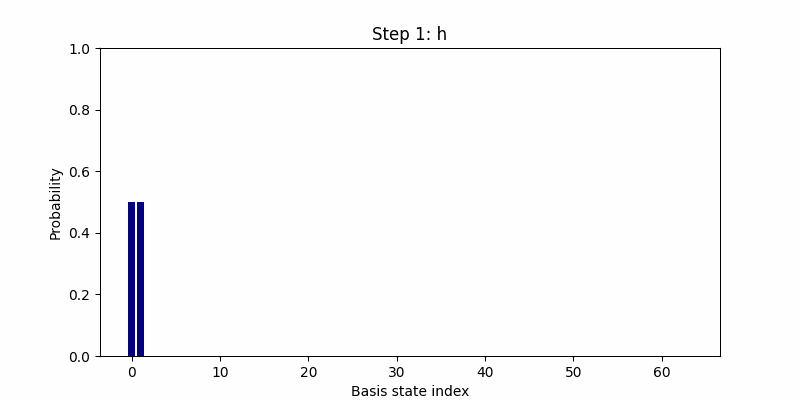

In [28]:
from IPython.display import Image
Image(filename="state_evolution.gif")

In [41]:
# Block 9 – Classical Post-processing to Extract Factors of 15
from math import gcd
from sympy import Rational

# Get measurement results
result = backend.run(tqc).result()
counts = result.get_counts()

print("Measurement counts:", counts)

# Choose the most frequent result
measured = max(counts, key=counts.get)
print("Most likely measured value:", measured)

# Convert binary string (little endian) to int
measured_int = int(measured, 2)
print("Measured integer (x):", measured_int)

# N is the number we want to factor
N = 15

# Step 1: Get the fraction x / 2^n_count
frac = Rational(measured_int, 2**n_count).limit_denominator(N)
s, r = frac.as_numer_denom()  # s/r is approx measured_int / 2^n_count
print(f"Fraction approximation: {s}/{r}, so candidate period r = {r}")

# Step 2: Check if r gives valid factors
if r % 2 != 0:
    print("Period r is odd; retry might be needed.")
else:
    # Compute candidate factors
    guess1 = gcd(a**(r//2) - 1, N)
    guess2 = gcd(a**(r//2) + 1, N)
    print(f"Candidate factors: {guess1}, {guess2}")

Measurement counts: {'100': 104, '101': 123, '000': 131, '010': 141, '110': 123, '001': 144, '011': 127, '111': 131}
Most likely measured value: 001
Measured integer (x): 1
Fraction approximation: 1/8, so candidate period r = 8
Candidate factors: 15, 1
